In [2]:
import pandas as pd
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import pickle
from collections import Counter
import timeit
import copy
###
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import igraph
import seaborn
###import packages
from scEasyMode import mousefilter
from scEasyMode import clusterplot
from scEasyMode import pymulti
from scEasyMode import sceasy
###
sc.set_figure_params(dpi=120,vector_friendly=False,format='pdf')

ImportError: Bio.Alphabet has been removed from Biopython. In many cases, the alphabet can simply be ignored and removed from scripts. In a few cases, you may need to specify the ``molecule_type`` as an annotation on a SeqRecord for your script to work correctly. Please see https://biopython.org/wiki/Alphabet for more information.

## readin data

In [2]:
###readin
osi= sceasy.read('osi_only.preprocessed')

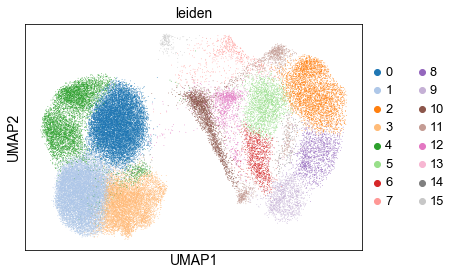

In [3]:
sc.pl.umap(osi,color='leiden',save='leiden.pdf')

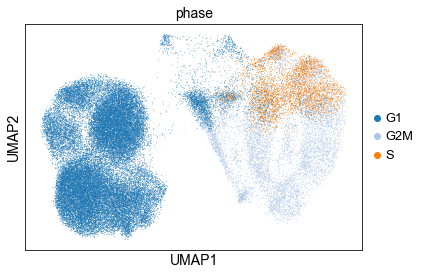

In [4]:
sc.pl.umap(osi,color='phase',save='phase.pdf')

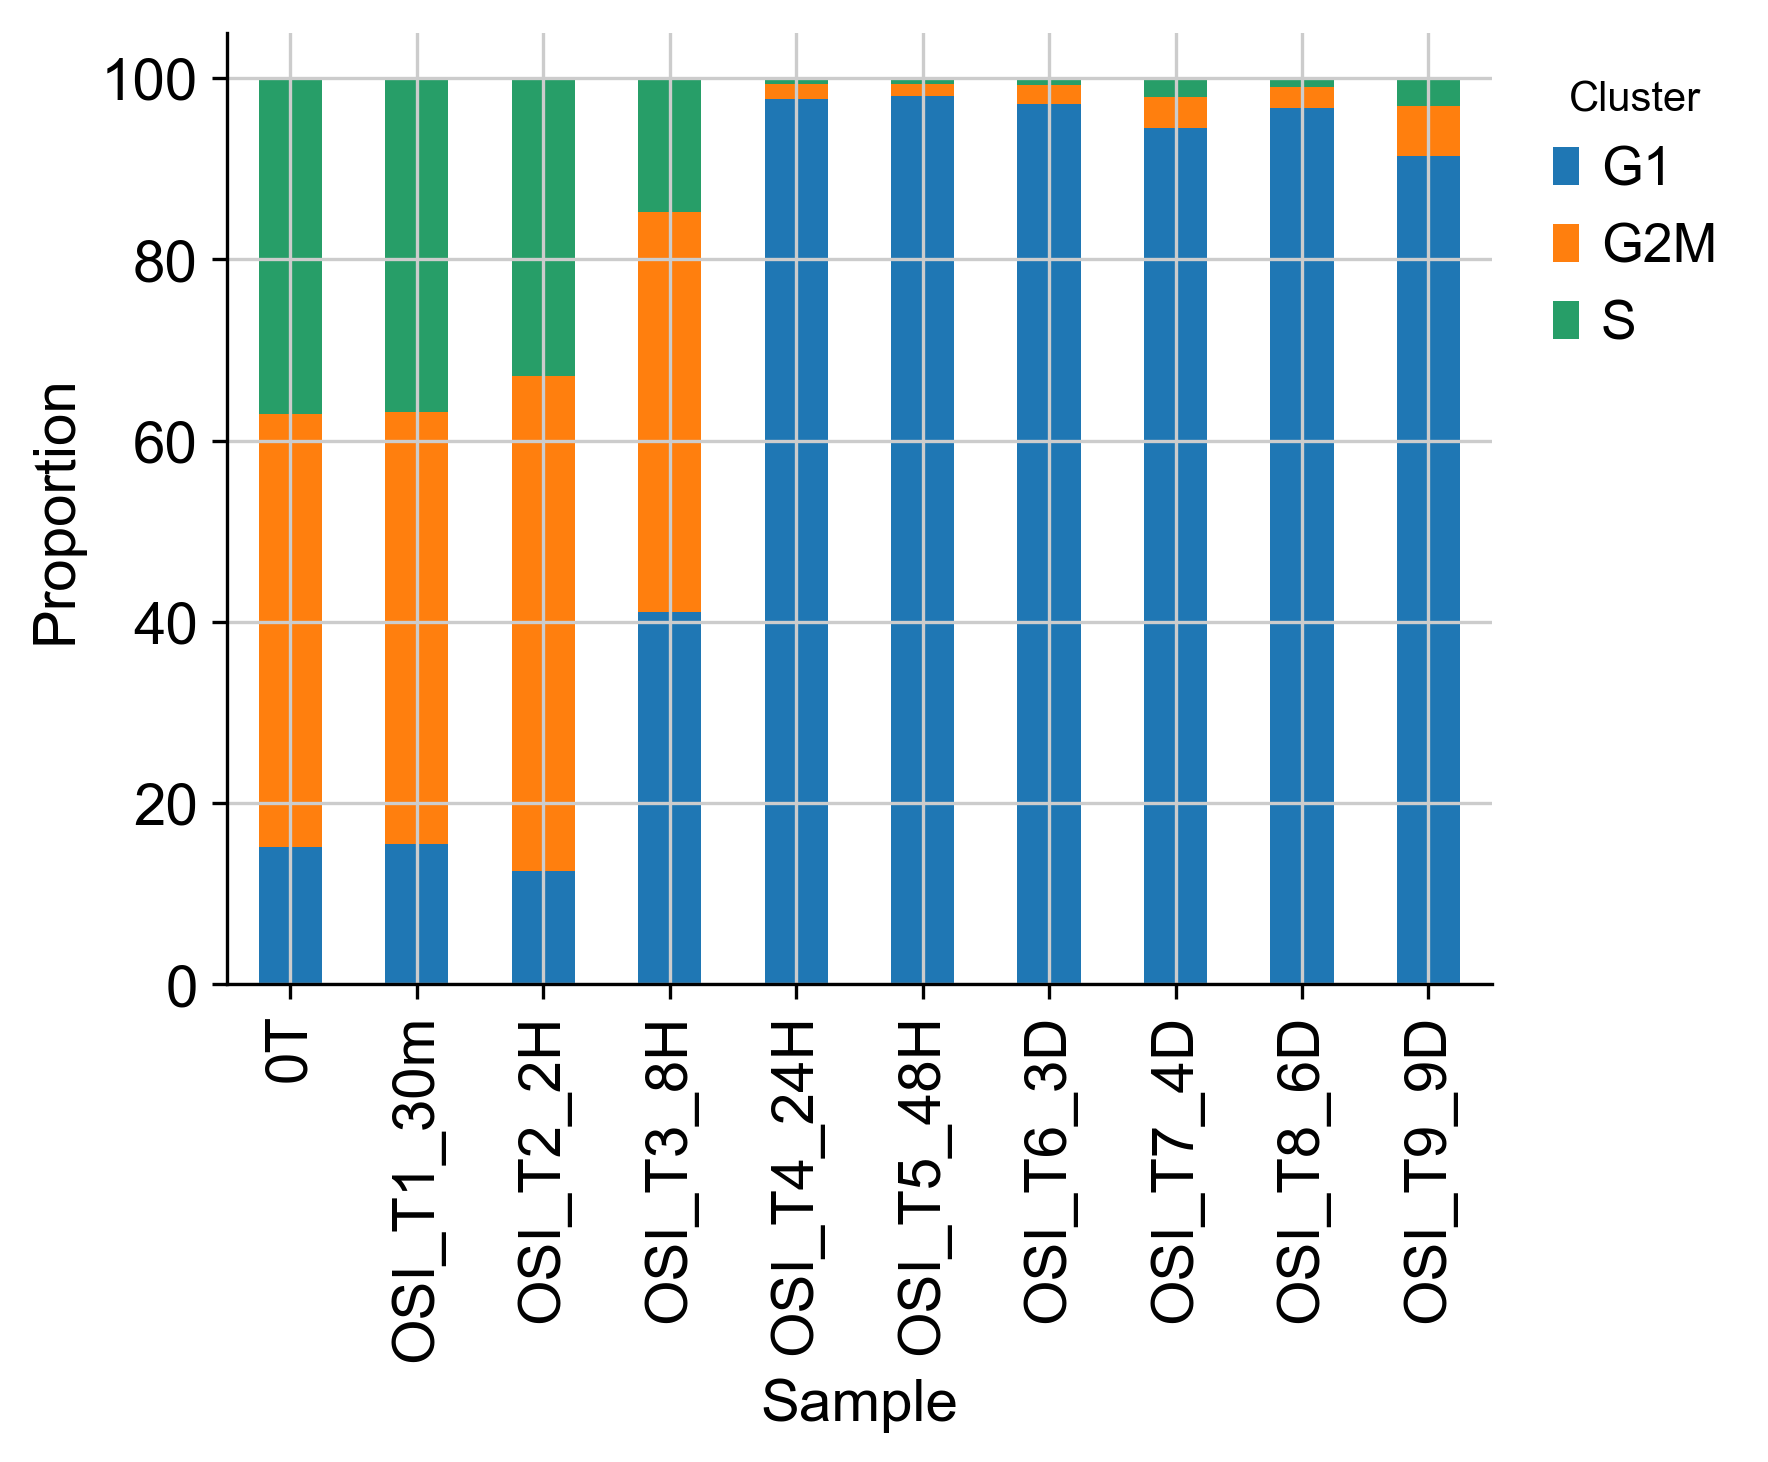

In [5]:
clusterplot.plot(osi,covariates=['phase'],sample='sample')
plt.xticks(rotation=90)
plt.savefig('figures/phase.stacked.pdf')

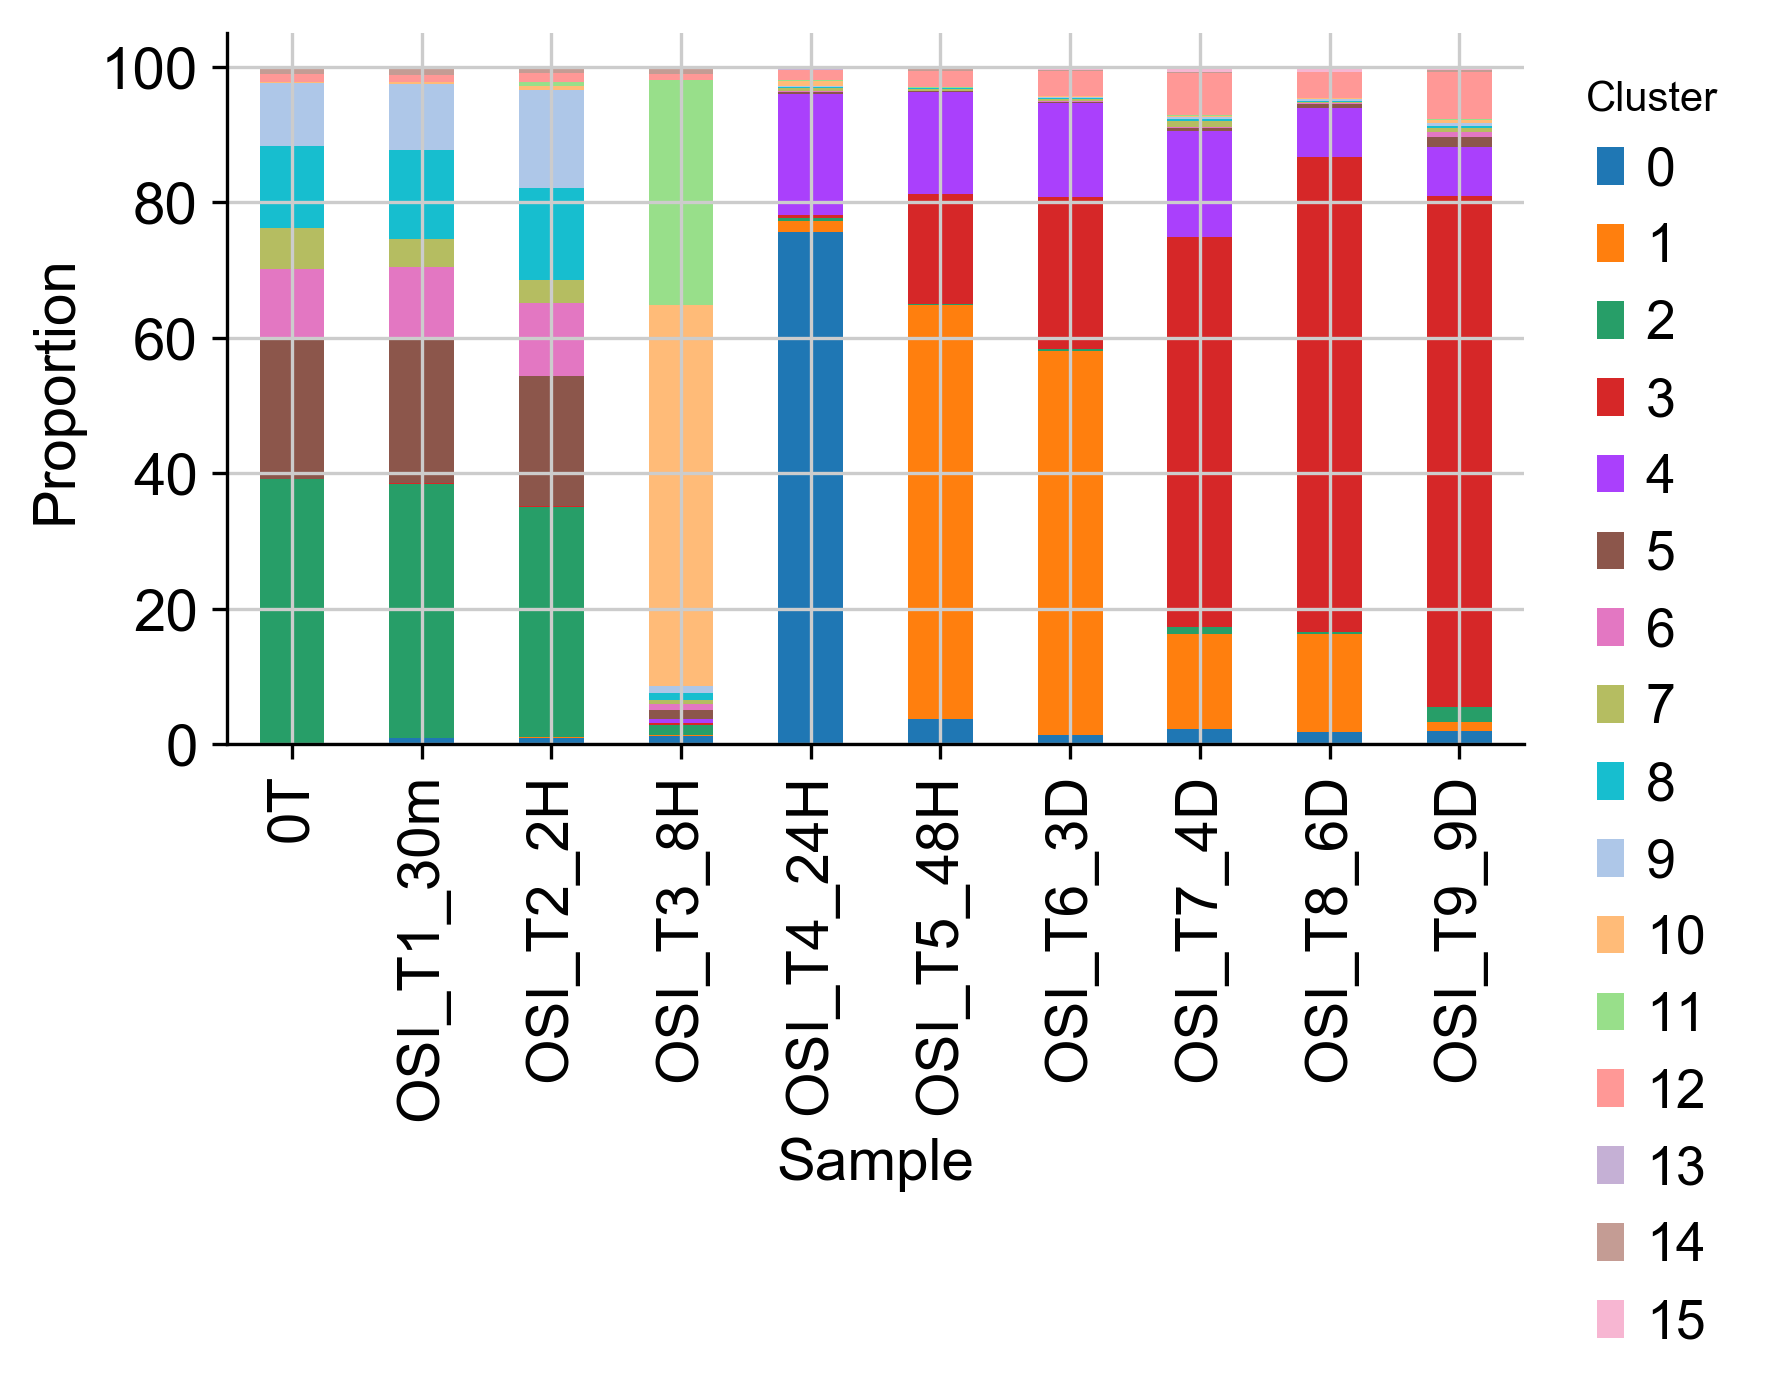

In [6]:
clusterplot.plot(osi,covariates=['leiden'],sample='sample')
plt.xticks(rotation=90)
plt.savefig('figures/leiden.stacked.pdf')

## overlay gbcs into scdata

In [7]:
###define functions for splitting gbcs into the scdata
def if_batch(dicts,row):
    tmp_dict = dicts[int(row.batch)]
    ###
    if row.barcode in tmp_dict.keys():
        return(tmp_dict[row.barcode])
    else:
        return('NA')
    
def overlay_gbcs(adata,calls,sigs,label1='sig_gbc',label2='call_gbc'):
    ###write into .obs
    adata.obs[label1] = adata.obs.apply(lambda row: if_batch(calls,row),axis=1)
    adata.obs[label2] = adata.obs.apply(lambda row: if_batch(sigs,row),axis=1)
    ###return
    return(adata)

In [8]:
###read in the scdata
gbcs = ['097','098','099',100,101,102,103,104]
calls = []
sigs = []
###
for gbc in gbcs:
    gbc_df = pd.read_csv('pymulti/GBCs_'+str(gbc)+'_calls.tsv',sep='\t',index_col=0)[['call','sig']]
    ###convert to dictionary
    mdict1 = gbc_df.to_dict()[gbc_df.columns[0]]
    mdict2 = gbc_df.to_dict()[gbc_df.columns[1]]
    ###append by batch #
    calls.append(mdict1)
    sigs.append(mdict2)

In [9]:
###overlay the osi gbcs 
osi = overlay_gbcs(osi,calls,sigs)

Trying to set attribute `.obs` of view, making a copy.


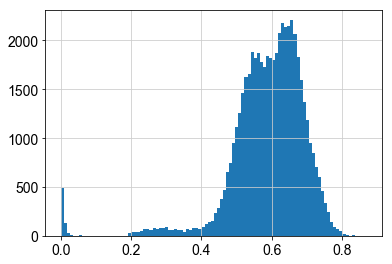

In [10]:
###subset and filter
osi = osi[osi.obs['sig_gbc']!='NA']
osi.obs.call_gbc = osi.obs.call_gbc.astype('float32')
osi.obs.sig_gbc = osi.obs.sig_gbc.astype('str')
osi.obs['call_gbc'].hist(bins=100)
osi = osi[osi.obs.call_gbc>=0.45]

In [11]:
osi.shape

(50116, 14296)

Trying to set attribute `.obs` of view, making a copy.
... storing 'sig_gbc' as categorical


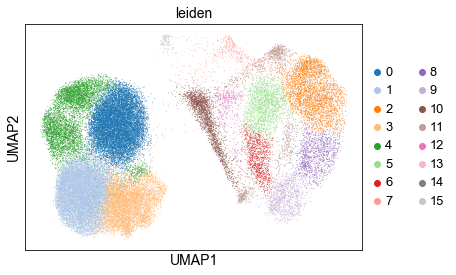

In [12]:
sc.pl.umap(osi,color='leiden')

In [13]:
### change things over into continuous time
sample_dict = {
    '0T':0,
    'OSI_T1_30m':0.5,
    'OSI_T2_2H':2,
    'OSI_T3_8H':8,
    'OSI_T4_24H':24,
    'OSI_T5_48H':48,
    'OSI_T6_3D':72,
    'OSI_T7_4D':96,
    'OSI_T8_6D':144,
    'OSI_T9_9D':216,
}
###
osi.obs['time'] = osi.obs.apply(lambda row: sample_dict[row['sample']],axis=1) 

In [14]:
# top_bcs = osi.obs.sig_gbc.value_counts().index.tolist()
# ratios = []
# ##calculate ratios in each cluster for each barcode
# for bc in top_bcs:
#     ## subset by barcode
#     tmp = osi[osi.obs.sig_gbc==bc]
#     #######
#     tmpratios = []
#     ####### subset by timepoint
#     for time in set(osi.obs.time):
#         tmptime = tmp[tmp.obs.time==time]
#         ## calculate ratios
#         tmpratio = tmptime.obs.leiden.value_counts()
#         tmpratio = tmpratio/len(tmptime.obs)
#         tmpratio = tmpratio.sort_index()
#         tmpratio = tmpratio.rename(str(time))
#         tmpratios.append(tmpratio)
#     ####### 
#     newratio = pd.concat(tmpratios,axis=1).fillna(value=0)
#     newratio.index.name = bc
#     newratio.index = newratio.index.astype('int')
#     newratio = pd.DataFrame(newratio.stack())
#     newratio.index.set_names(['cluster','timepoint'],inplace=True)
#     ratios.append(newratio)
#     ## calculate ratios
#     #tmpratio = tmp.obs.leiden.value_counts()/len(tmp.obs)
#     #tmpratio = tmpratio.sort_index()
#     #tmpratio = tmpratio.rename(bc)
#     #ratios.append(tmpratio)
# ##join
# #ratiodf = pd.concat(ratios,axis=1)


In [15]:
# ratiodf = pd.concat(ratios,axis=1)
# ratiodf.columns = top_bcs
# ratiodf.fillna(value=0,inplace=True)
# #ratiodf = ratiodf.reorder_levels(order=['timepoint','cluster'])
# ratiodf = ratiodf.sort_index()

## visualize movement of cells by cluster-time

In [16]:
# clusts = seaborn.clustermap(ratiodf,cmap='Purples',row_cluster=False,method='ward',metric='euclidean',figsize=(20,20),vmin=0.2,vmax=0.8,center=0.5)
# clusts.savefig('figures/barcodes.clust.pdf')

## Clearly there is a pattern here of different barcodes having different transcriptional profiles
#### need to get the clustering of these barcodes; top N clusters

In [17]:
def densitymap(adata,sample_key='sample',save=None):
    """ Plots the density of samples across umap space 
        adata = anndata object to act on
        key = the key on which to split the dataset and visualize samples individually.
        
        Returns a plot to the interpreter.
    """ 
    sc.tl.embedding_density(adata, basis='umap', groupby=sample_key)
    sc.pl.embedding_density(adata, basis='umap', key='umap_density_'+sample_key,save=save)

In [18]:
# import scipy.cluster.hierarchy as sch
# ####
# numclusts = 2
# rngclusts = range(1,numclusts+1)
# ####
# df = ratiodf.transpose().copy()

# # retrieve clusters using fcluster 
# d = sch.distance.pdist(df,metric='euclidean')
# L = sch.linkage(d, method='ward')
# # 0.2 can be modified to retrieve more stringent or relaxed clusters
# clusters = sch.fcluster(L, t=numclusts, criterion='maxclust')
# # clusters indicices correspond to incides of original df
# clustering = []
# # subset clusters
# sets = []
# sets_sc = []
# ###
# for i,cluster in enumerate(clusters):
#     clustering.append([df.index[i], cluster])
# ###
# clustering = pd.DataFrame(clustering)
# clustering.columns = ['barcode','cluster']
# for clust in rngclusts:
#     tmpset = clustering[clustering['cluster']==clust]
#     tmpset = tmpset.barcode.tolist()
#     ##
#     sets.append(tmpset)
#     ##
#     sets_sc.append(osi[osi.obs.sig_gbc.isin(tmpset)])
# ###
# i=0
# for set_sc in sets_sc:
#     set_sc.obs.time = set_sc.obs.time.astype('str')
#     densitymap(set_sc,sample_key='time',save='set'+str(i)+'.pdf')
#     i+=1

## subcluster post 24 hours stuff

In [28]:
###keep only relevant timepoint cells
osi = osi[osi.obs.time>=24.0]
keep = osi.obs.index.tolist()

In [33]:
###readin
merged = sceasy.read('merged_raw')
###subset
merged = merged[merged.obs.index.isin(keep)]

Trying to set attribute `.var` of view, making a copy.
/home/johnny/.local/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../home/johnny/.local/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/johnny/.local/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".

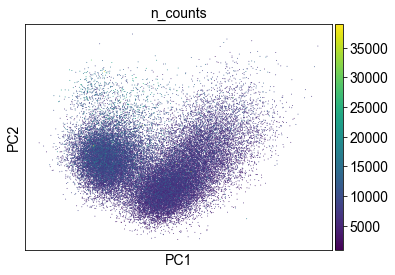

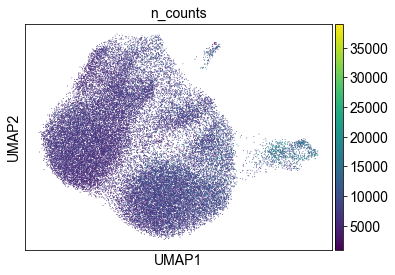

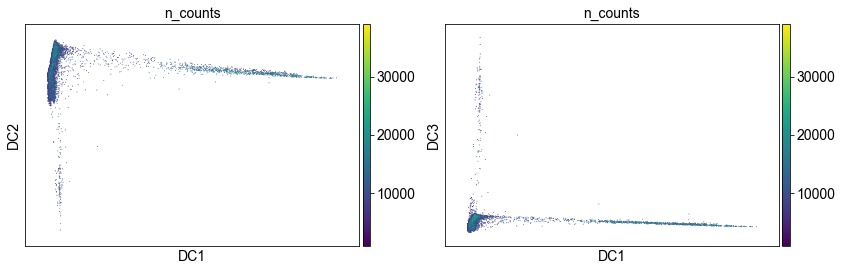

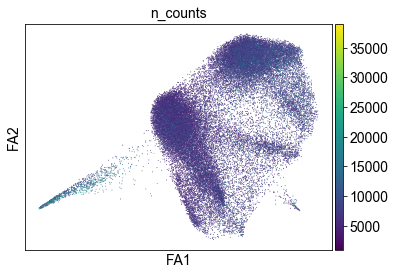

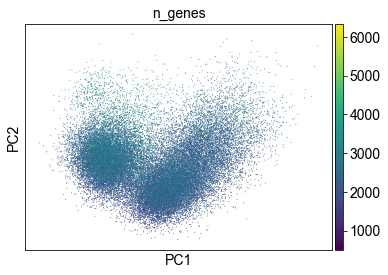

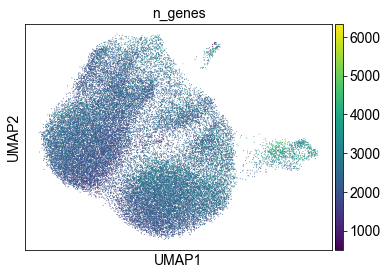

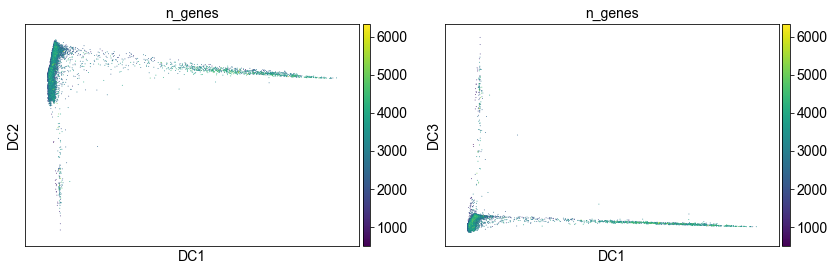

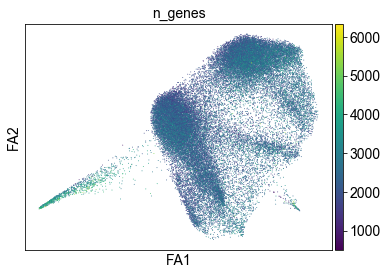

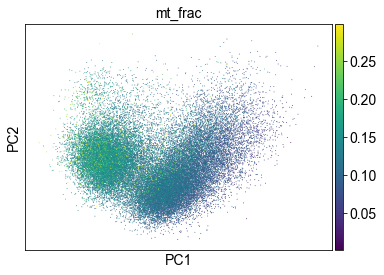

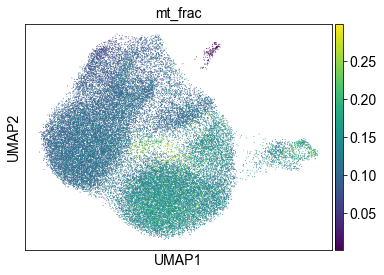

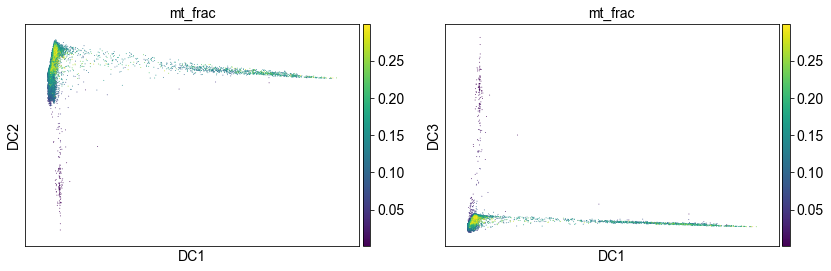

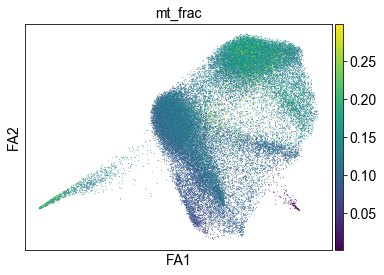

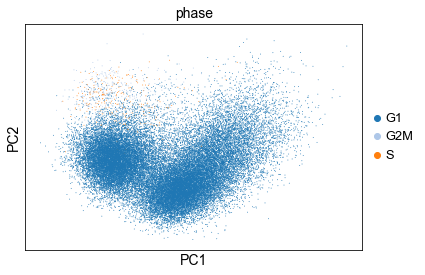

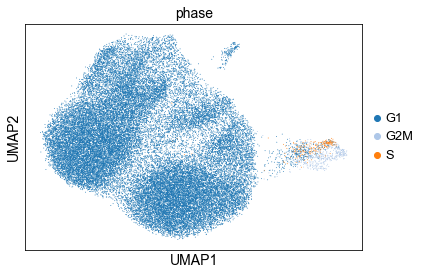

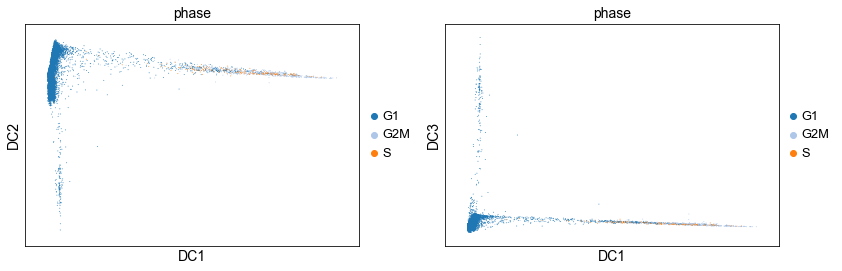

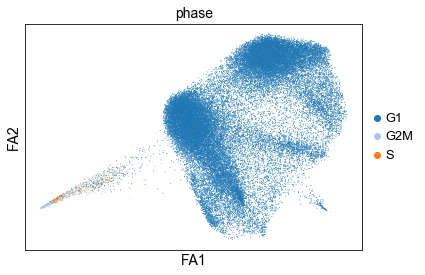

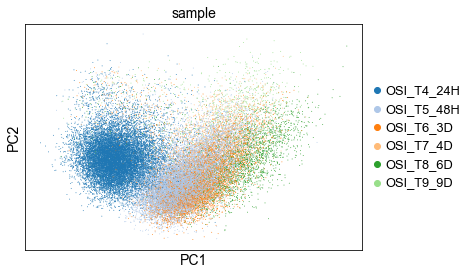

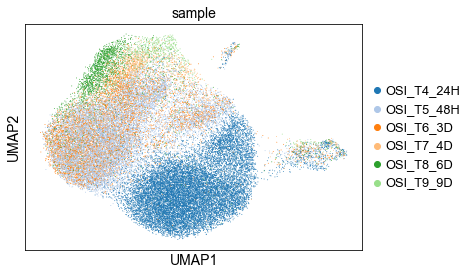

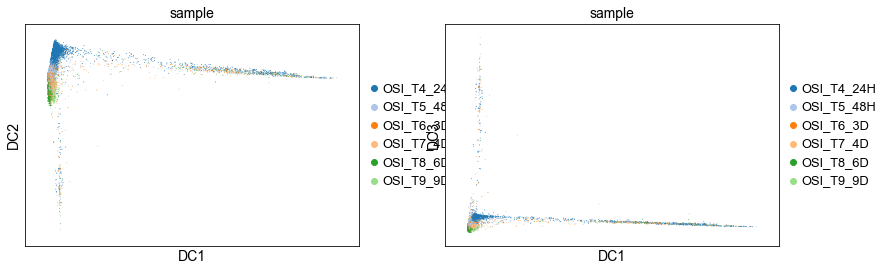

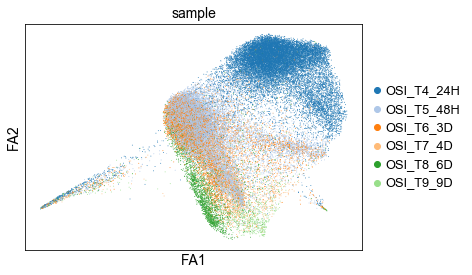

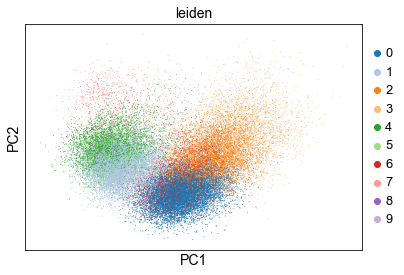

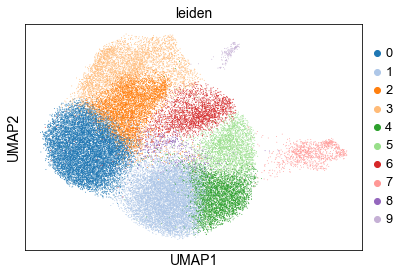

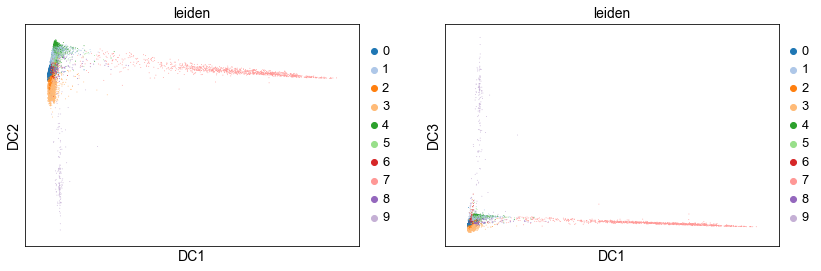

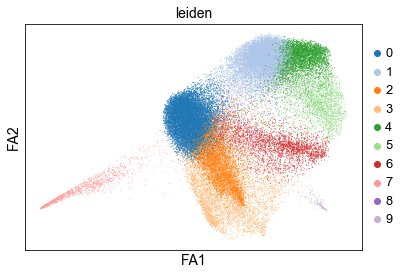

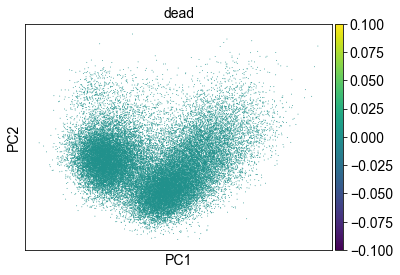

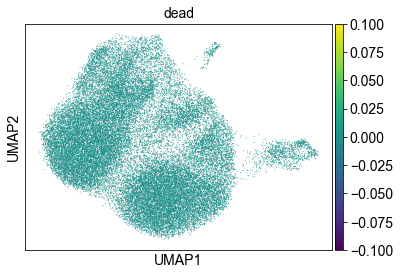

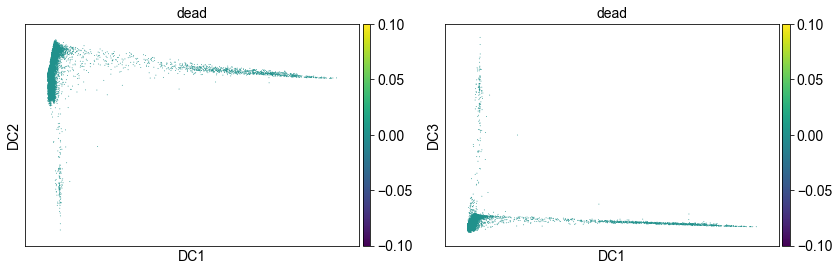

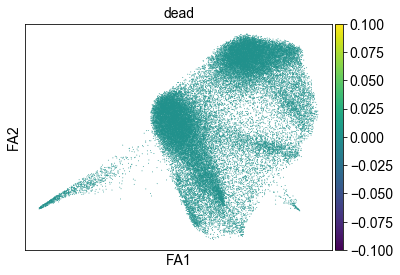

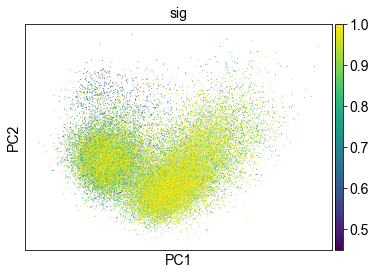

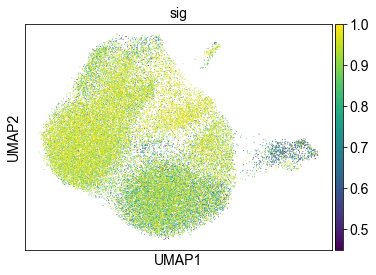

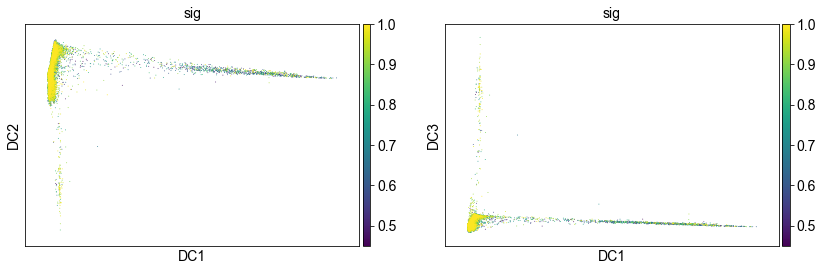

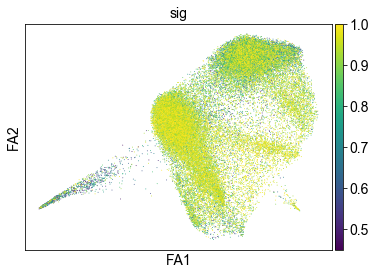

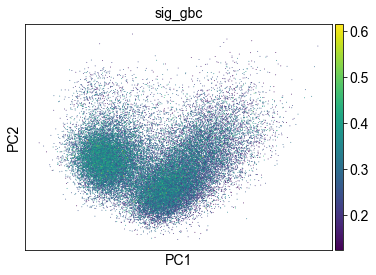

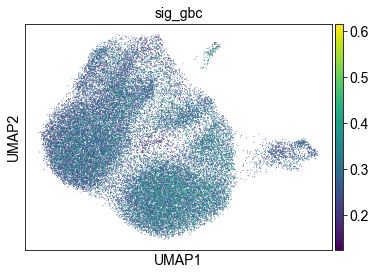

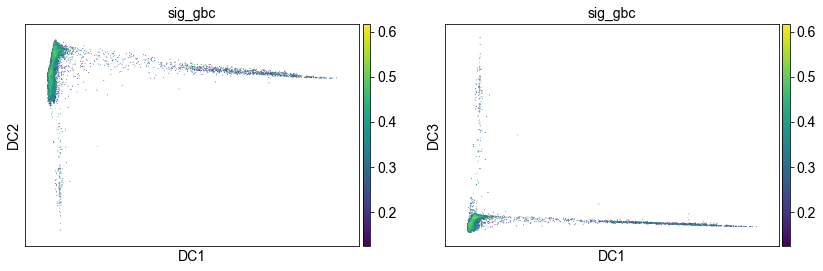

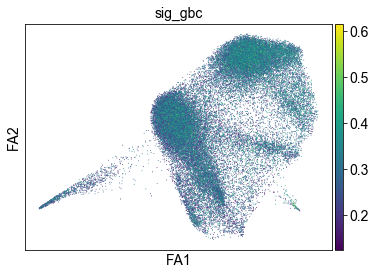

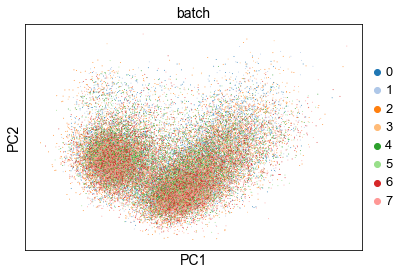

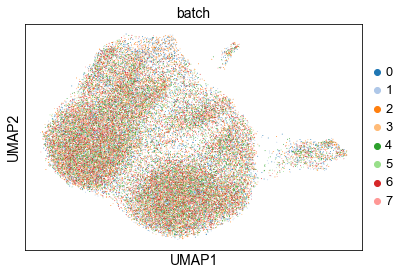

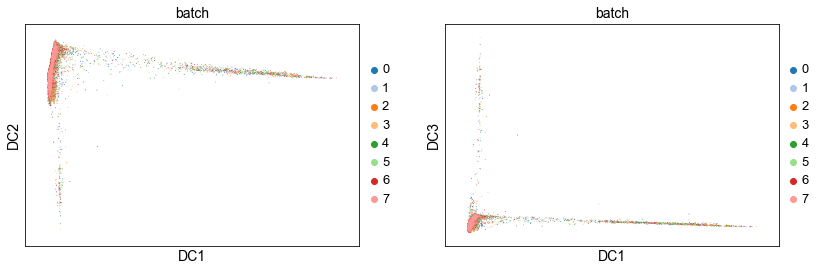

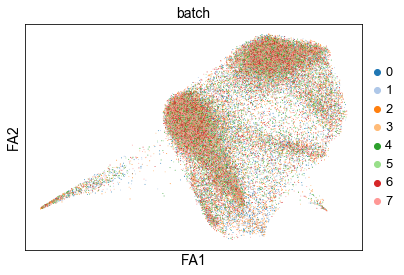

In [34]:

##visualize
res = 1.0
n_genes = 3000
sc.pp.highly_variable_genes(merged, flavor='cell_ranger', n_top_genes=n_genes)
merged = sceasy.visualize(merged,covariates=['n_counts','n_genes','mt_frac','phase','sample','leiden','dead','sig','sig_gbc','batch',],res=res)

In [35]:
##save
sceasy.save(merged,'merged_post24h')

## redo analysis

In [3]:
osi = sceasy.read('merged_post24h')

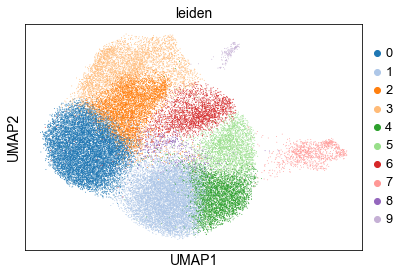

In [4]:
sc.pl.umap(osi,color='leiden',save='leiden.pdf')

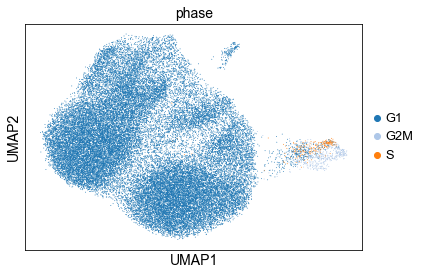

In [5]:
sc.pl.umap(osi,color='phase',save='phase.pdf')

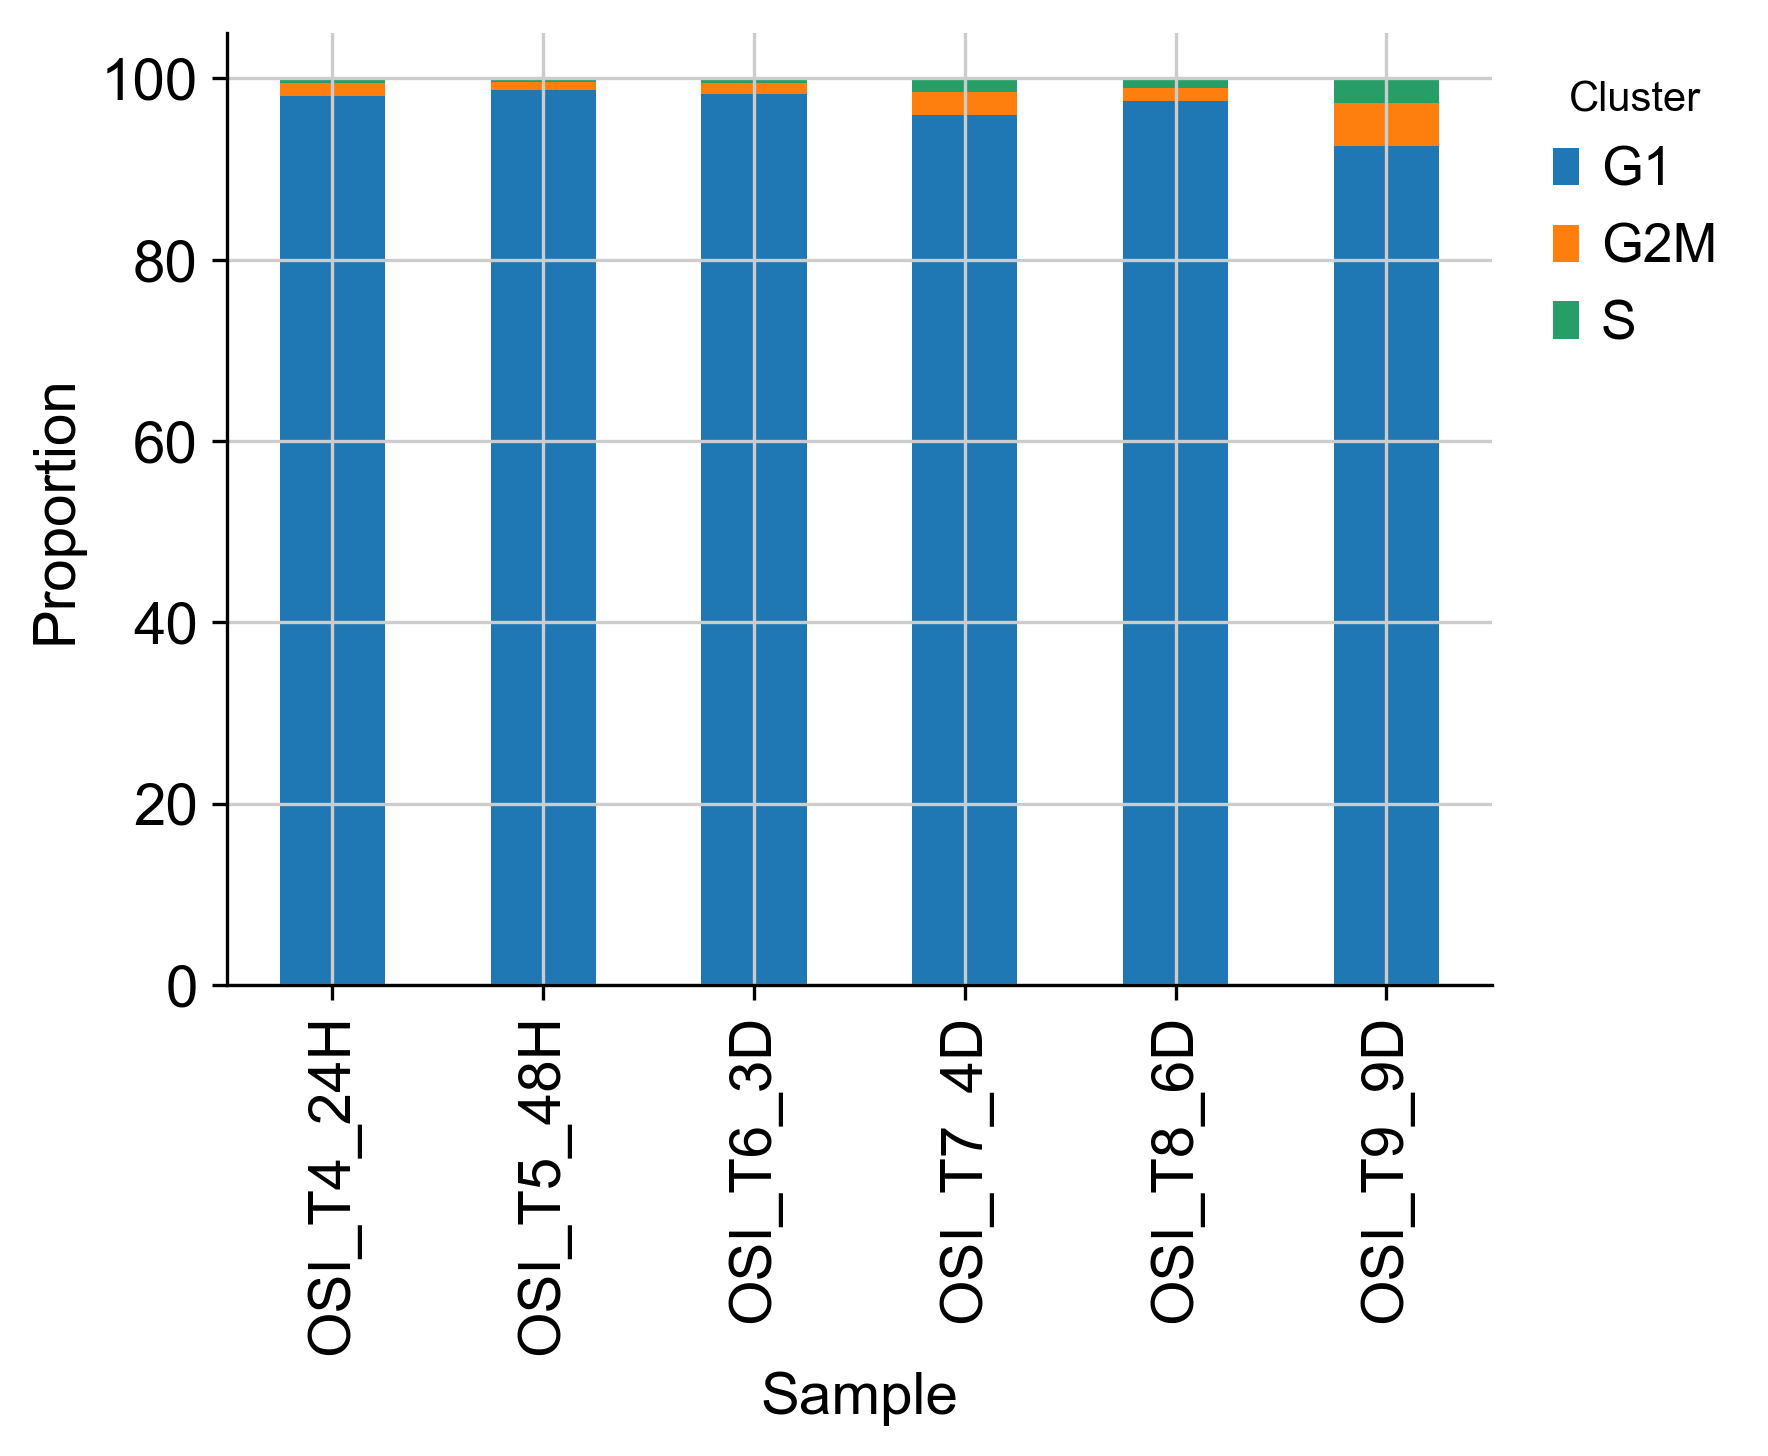

In [6]:
clusterplot.plot(osi,covariates=['phase'],sample='sample')
plt.xticks(rotation=90)
plt.savefig('figures/phase.stacked.pdf')

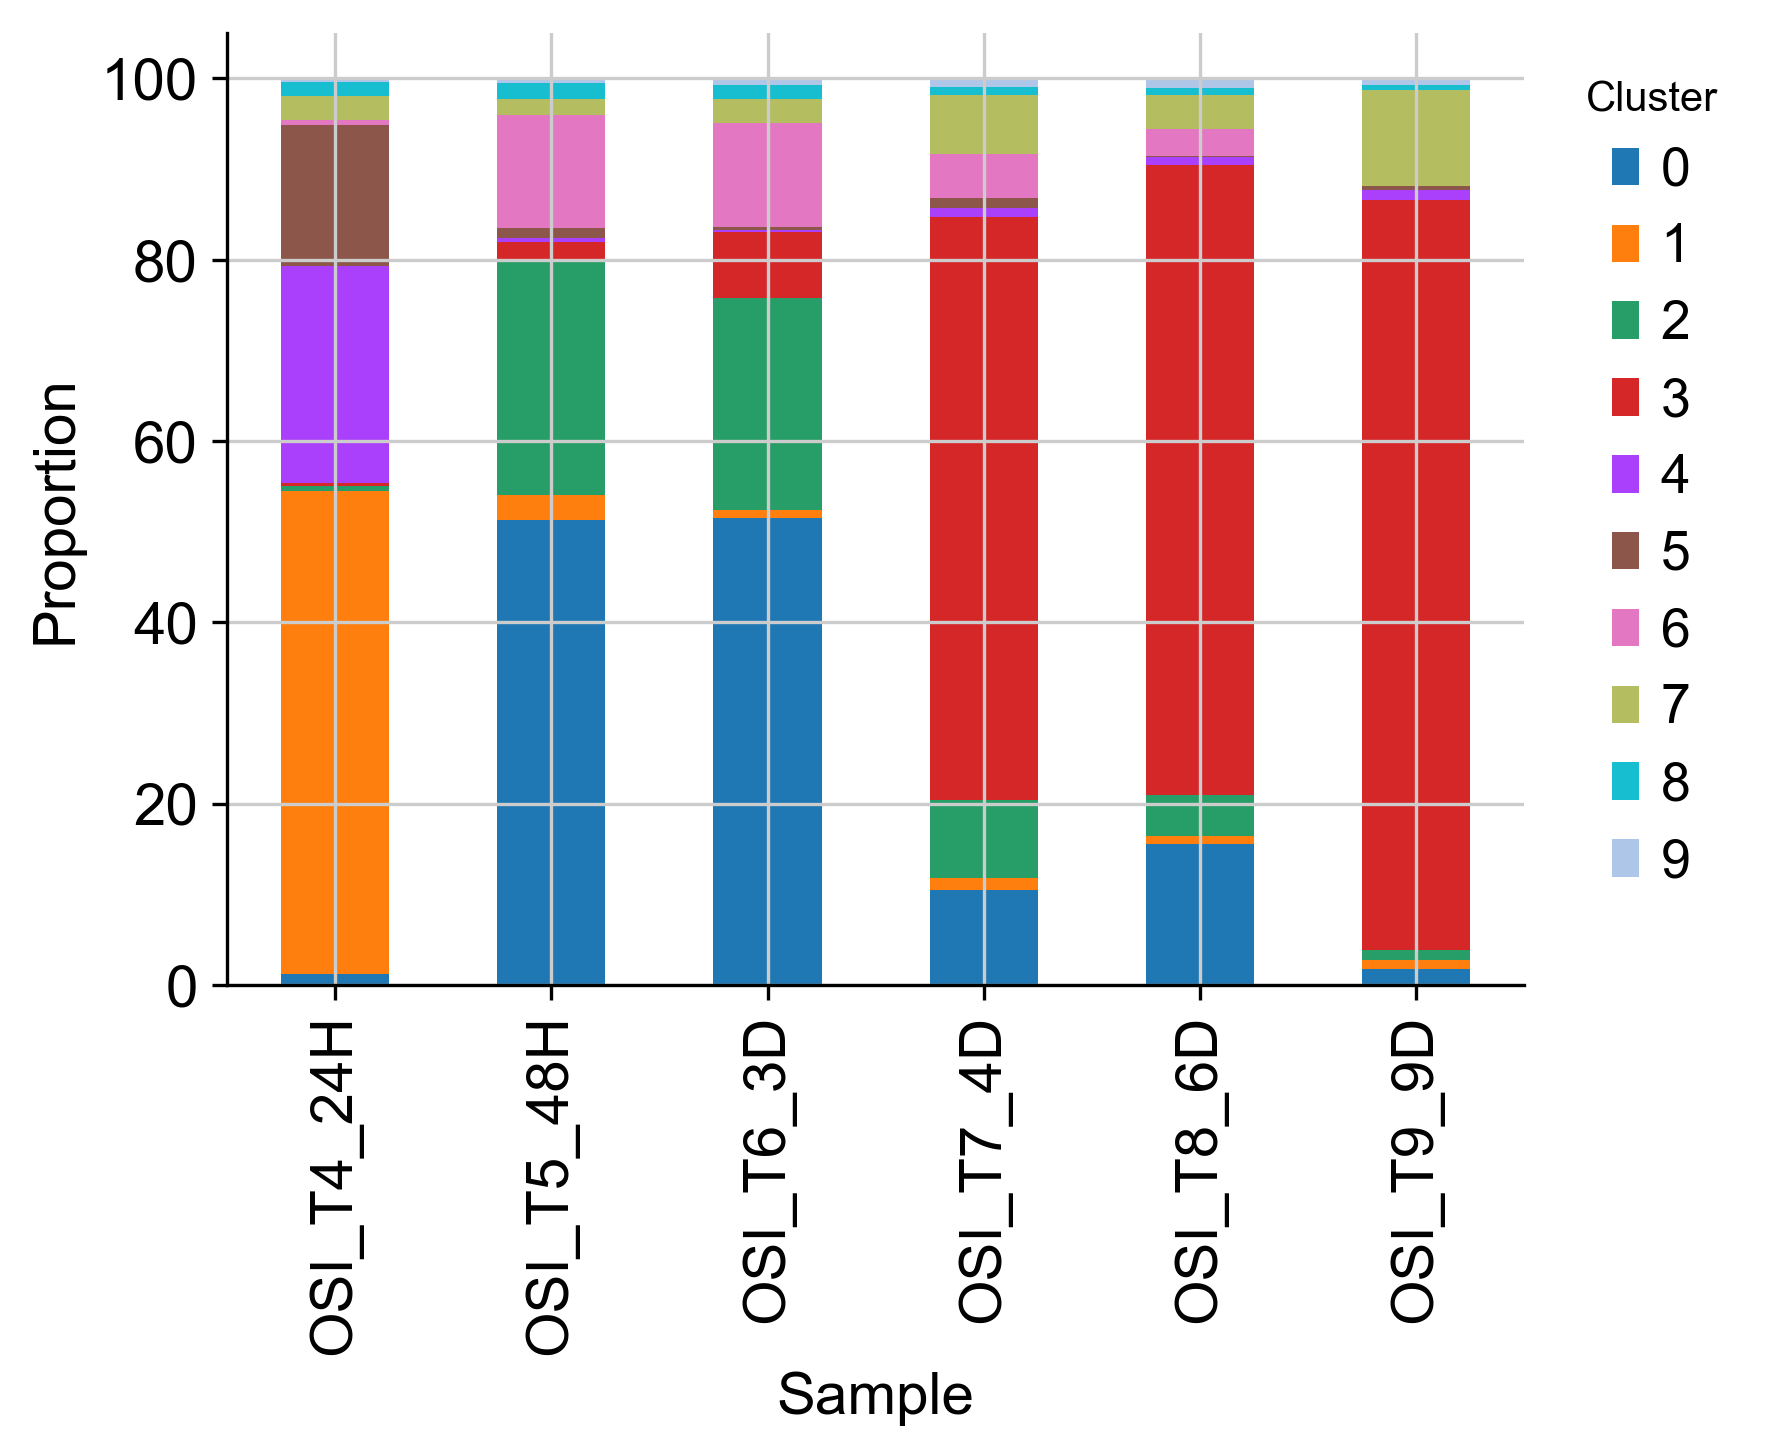

In [7]:
clusterplot.plot(osi,covariates=['leiden'],sample='sample')
plt.xticks(rotation=90)
plt.savefig('figures/leiden.stacked.pdf')

## overlay gbcs into scdata

In [8]:
###define functions for splitting gbcs into the scdata
def if_batch(dicts,row):
    tmp_dict = dicts[int(row.batch)]
    ###
    if row.barcode in tmp_dict.keys():
        return(tmp_dict[row.barcode])
    else:
        return('NA')
    
def overlay_gbcs(adata,calls,sigs,label1='sig_gbc',label2='call_gbc'):
    ###write into .obs
    adata.obs[label1] = adata.obs.apply(lambda row: if_batch(calls,row),axis=1)
    adata.obs[label2] = adata.obs.apply(lambda row: if_batch(sigs,row),axis=1)
    ###return
    return(adata)

In [9]:
###read in the scdata
gbcs = ['097','098','099',100,101,102,103,104]
calls = []
sigs = []
###
for gbc in gbcs:
    gbc_df = pd.read_csv('pymulti/GBCs_'+str(gbc)+'_calls.tsv',sep='\t',index_col=0)[['call','sig']]
    ###convert to dictionary
    mdict1 = gbc_df.to_dict()[gbc_df.columns[0]]
    mdict2 = gbc_df.to_dict()[gbc_df.columns[1]]
    ###append by batch #
    calls.append(mdict1)
    sigs.append(mdict2)

In [10]:
###overlay the osi gbcs 
osi = overlay_gbcs(osi,calls,sigs)

Trying to set attribute `.obs` of view, making a copy.


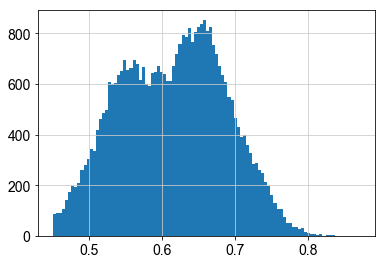

In [11]:
###subset and filter
osi = osi[osi.obs['sig_gbc']!='NA']
osi.obs.call_gbc = osi.obs.call_gbc.astype('float32')
osi.obs.sig_gbc = osi.obs.sig_gbc.astype('str')
osi.obs['call_gbc'].hist(bins=100)
osi = osi[osi.obs.call_gbc>=0.45]

In [12]:
osi.shape

(37558, 14296)

Trying to set attribute `.obs` of view, making a copy.
... storing 'sig_gbc' as categorical


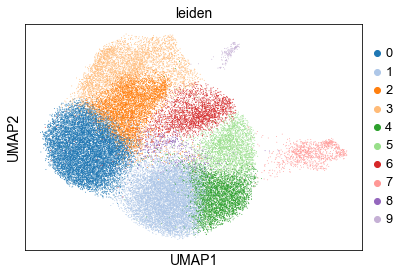

In [13]:
sc.pl.umap(osi,color='leiden')

In [14]:
### change things over into continuous time
sample_dict = {
    '0T':0,
    'OSI_T1_30m':0.5,
    'OSI_T2_2H':2,
    'OSI_T3_8H':8,
    'OSI_T4_24H':24,
    'OSI_T5_48H':48,
    'OSI_T6_3D':72,
    'OSI_T7_4D':96,
    'OSI_T8_6D':144,
    'OSI_T9_9D':216,
}
###
osi.obs['time'] = osi.obs.apply(lambda row: sample_dict[row['sample']],axis=1) 

In [15]:
top_bcs = osi.obs.sig_gbc.value_counts().index.tolist()
ratios = []
##calculate ratios in each cluster for each barcode
for bc in top_bcs:
    ## subset by barcode
    tmp = osi[osi.obs.sig_gbc==bc]
    #######
    tmpratios = []
    ####### subset by timepoint
    for time in set(osi.obs.time):
        tmptime = tmp[tmp.obs.time==time]
        ## calculate ratios
        tmpratio = tmptime.obs.leiden.value_counts()
        tmpratio = tmpratio/len(tmptime.obs)
        tmpratio = tmpratio.sort_index()
        tmpratio = tmpratio.rename(str(time))
        tmpratios.append(tmpratio)
    ####### 
    newratio = pd.concat(tmpratios,axis=1).fillna(value=0)
    newratio.index.name = bc
    newratio.index = newratio.index.astype('int')
    newratio = pd.DataFrame(newratio.stack())
    newratio.index.set_names(['cluster','timepoint'],inplace=True)
    ratios.append(newratio)
    ## calculate ratios
    #tmpratio = tmp.obs.leiden.value_counts()/len(tmp.obs)
    #tmpratio = tmpratio.sort_index()
    #tmpratio = tmpratio.rename(bc)
    #ratios.append(tmpratio)
##join
#ratiodf = pd.concat(ratios,axis=1)


/avicenna/Johnny/envs/scanpy2/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


In [1]:
ratiodf = pd.concat(ratios,axis=1)
ratiodf.columns = top_bcs
ratiodf.fillna(value=0,inplace=True)
ratiodf = ratiodf.reorder_levels(order=['timepoint','cluster'])
ratiodf = ratiodf.sort_index()

NameError: name 'pd' is not defined

## visualize movement of cells by cluster-time

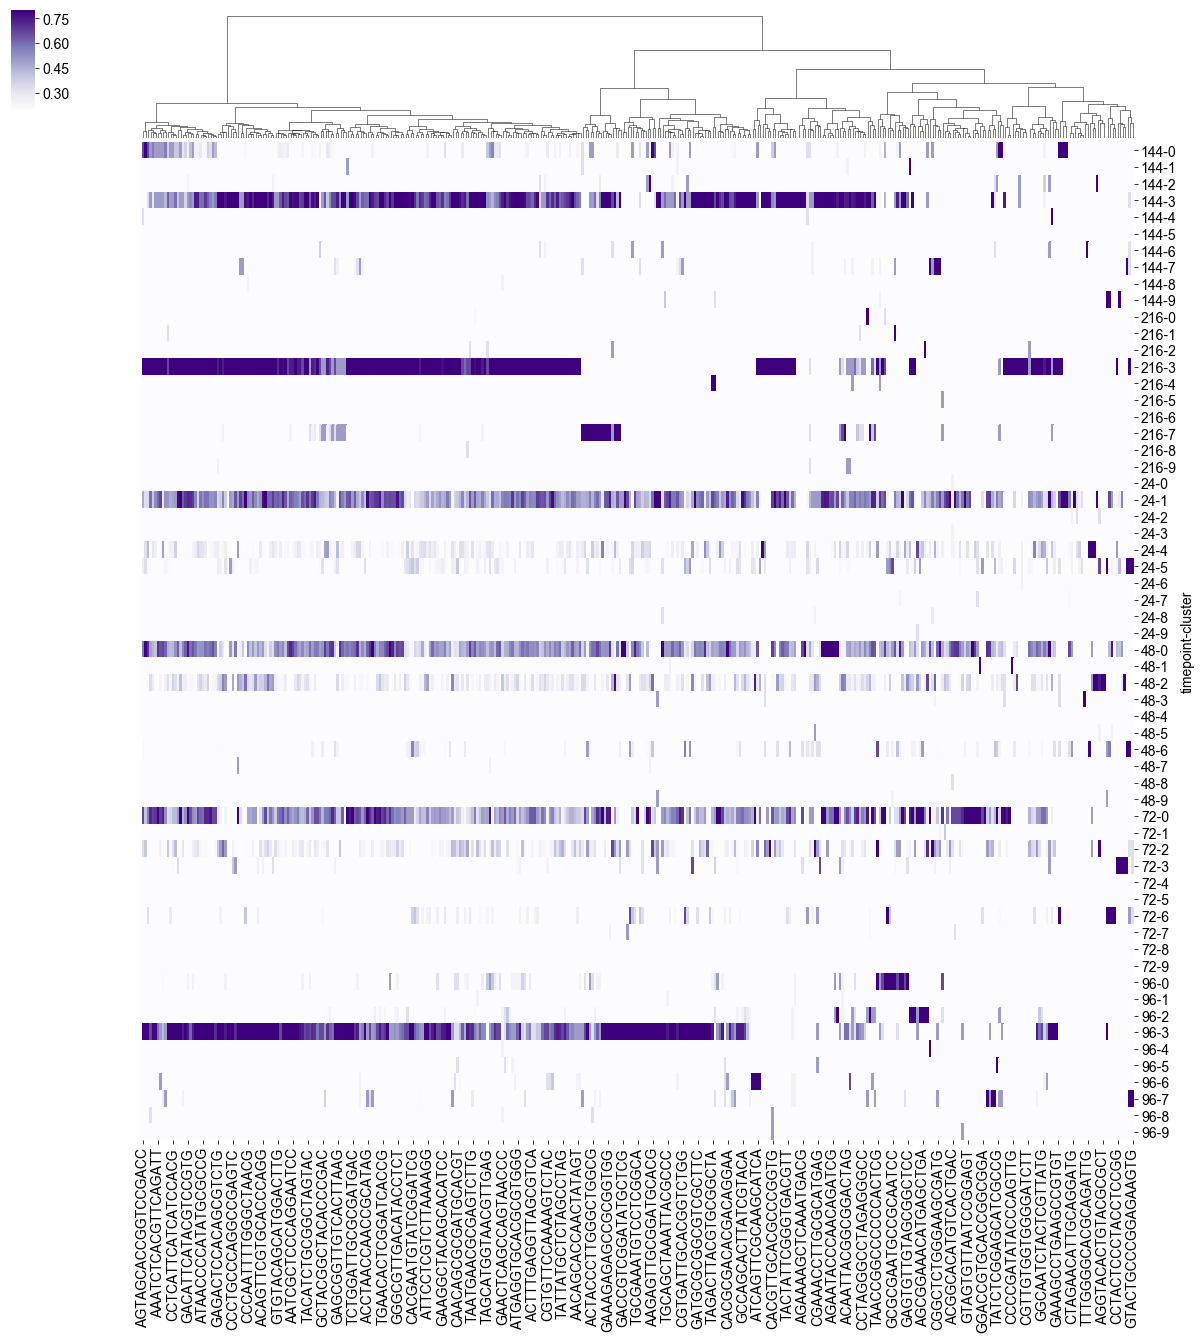

In [17]:
clusts = seaborn.clustermap(ratiodf,cmap='Purples',row_cluster=False,method='ward',metric='euclidean',figsize=(20,20),vmin=0.2,vmax=0.8,center=0.5)
# clusts.savefig('figures/barcodes.clust.pdf')

## Clearly there is a pattern here of different barcodes having different transcriptional profiles
#### need to get the clustering of these barcodes; top N clusters

In [18]:
def densitymap(adata,sample_key='sample',save=None):
    """ Plots the density of samples across umap space 
        adata = anndata object to act on
        key = the key on which to split the dataset and visualize samples individually.
        
        Returns a plot to the interpreter.
    """ 
    sc.tl.embedding_density(adata, basis='umap', groupby=sample_key)
    sc.pl.embedding_density(adata, basis='umap', key='umap_density_'+sample_key,save=save)

Trying to set attribute `.obs` of view, making a copy.
... storing 'time' as categorical


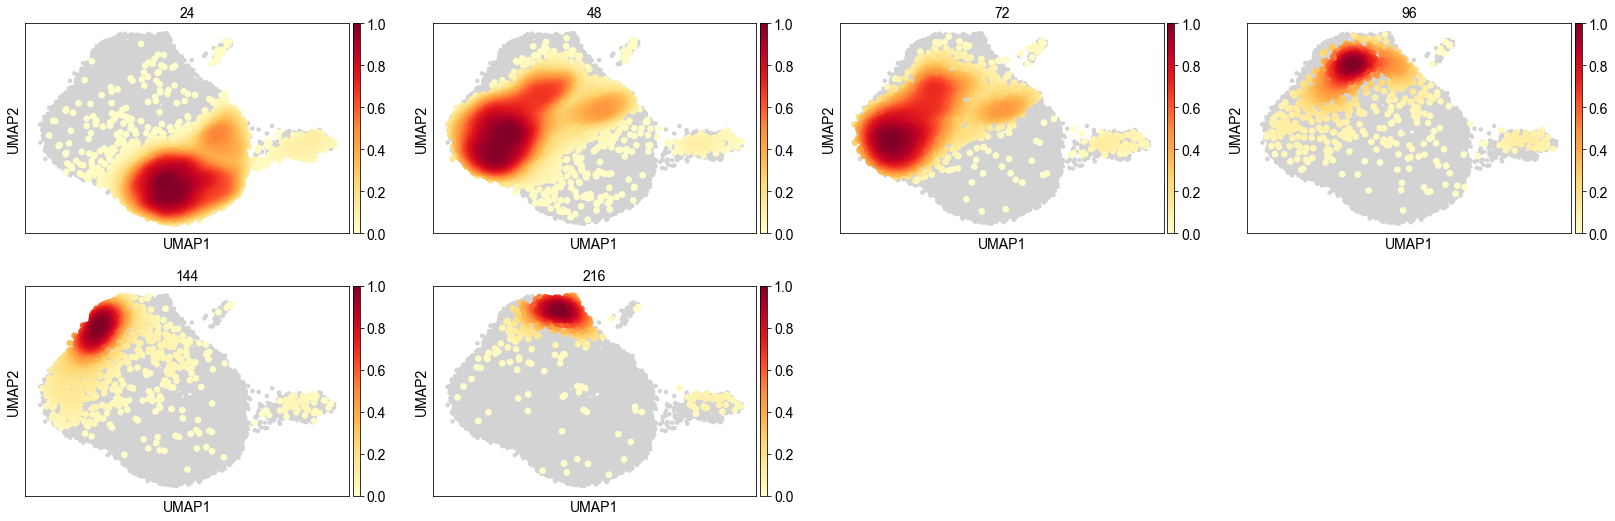

Trying to set attribute `.obs` of view, making a copy.
... storing 'time' as categorical


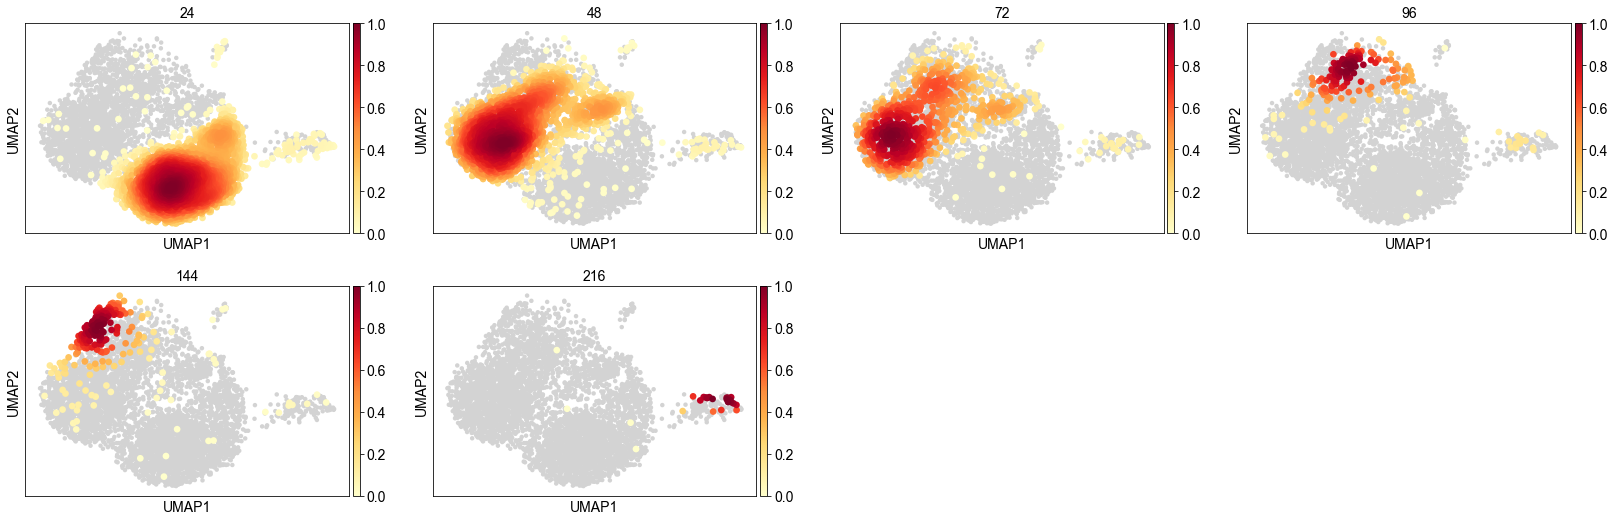

Trying to set attribute `.obs` of view, making a copy.
... storing 'time' as categorical


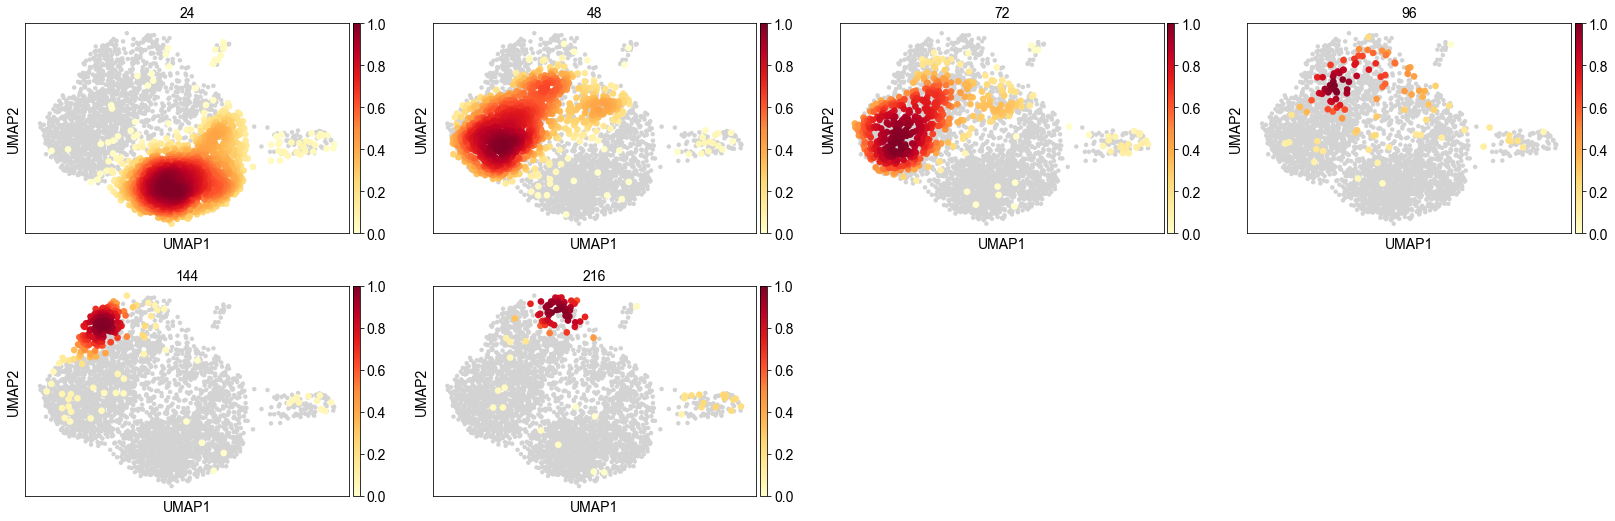

Trying to set attribute `.obs` of view, making a copy.
... storing 'time' as categorical


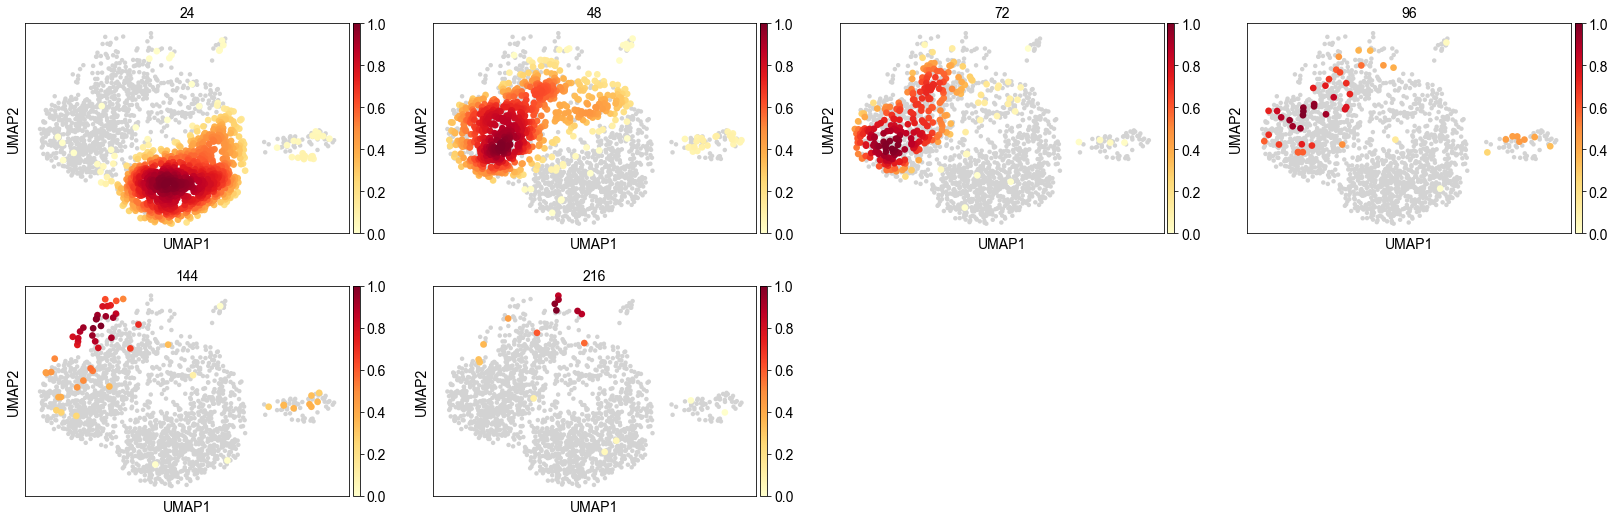

Trying to set attribute `.obs` of view, making a copy.
... storing 'time' as categorical


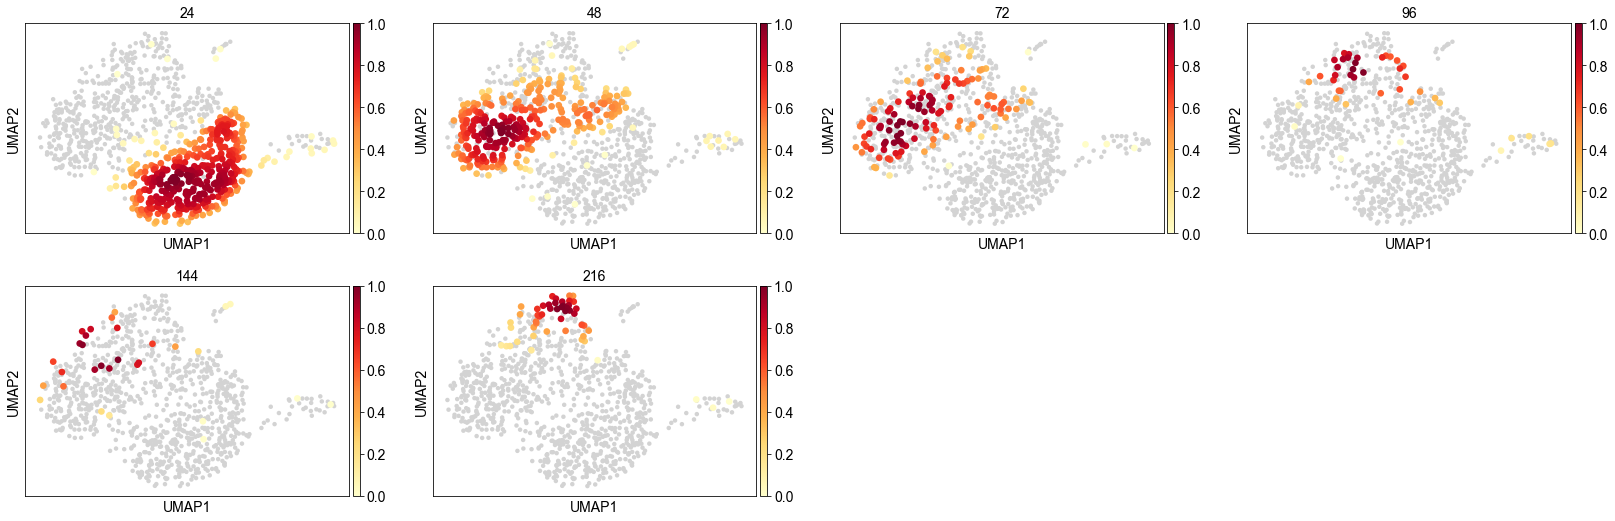

In [19]:
import scipy.cluster.hierarchy as sch
####
numclusts = 5
rngclusts = range(1,numclusts+1)
####
df = ratiodf.transpose().copy()

# retrieve clusters using fcluster 
d = sch.distance.pdist(df,metric='euclidean')
L = sch.linkage(d, method='ward')
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, t=numclusts, criterion='maxclust')
# clusters indicices correspond to incides of original df
clustering = []
# subset clusters
sets = []
sets_sc = []
###
for i,cluster in enumerate(clusters):
    clustering.append([df.index[i], cluster])
###
clustering = pd.DataFrame(clustering)
clustering.columns = ['barcode','cluster']
for clust in rngclusts:
    tmpset = clustering[clustering['cluster']==clust]
    tmpset = tmpset.barcode.tolist()
    ##
    sets.append(tmpset)
    ##
    sets_sc.append(osi[osi.obs.sig_gbc.isin(tmpset)])
###
i=0
for set_sc in sets_sc:
    set_sc.obs.time = set_sc.obs.time.astype('str')
    densitymap(set_sc,sample_key='time',save='set'+str(i)+'.pdf')
    i+=1

## Okay so these lineages are pretty much undergoing the same trajectories

### this tells us that grouping lineages by their transcriptomes is not a useful approach

### I will then try to group them by their selection pressure over time

In [40]:
top_bcs = osi.obs.sig_gbc.value_counts().index.tolist()
### get lengths
lens_time = []
times = []
for time in set(osi.obs.time):
    tmp = osi.obs[osi.obs.time==time]
    lens_time.append(len(tmp))
    times.append(time)
### get ratios per barcode
ratios = []
for bc in top_bcs:
    ## subset by barcode
    tmp = osi[osi.obs.sig_gbc==bc]
    ## calculate proportion of population at that timepoint
    tmpratios = []
    ## subset by timepoint
    i=0
    for time in set(osi.obs.time):
        tmptime = len(tmp.obs[tmp.obs.time==time])
        ## calculate ratios
        tmpratios.append(tmptime/lens_time[i])
        ##
        i+=1
    ratios.append(tmpratios)

In [41]:
ratiodf = pd.DataFrame(ratios,index=top_bcs,columns=times)
##
times.sort()
ratiodf = ratiodf[times]
ratiodf.fillna(value=0,inplace=True)


24        48        72        96        144       216
ATACAGTTACATCTCCTA  0.013468  0.014882  0.012002  0.005185  0.006247  0.002367
GATCCCCGGTACCGCCAG  0.010001  0.009492  0.011093  0.020091  0.010710  0.016568
ATTCCAGATTCCACGTAG  0.012134  0.009332  0.008911  0.010369  0.009371  0.001183
AGTCTCGATGCTTCCTTA  0.009934  0.009895  0.010911  0.012314  0.012941  0.004734
TCAACTGTGGCTGCCAGT  0.008334  0.010780  0.010002  0.018146  0.009817  0.009467
...                      ...       ...       ...       ...       ...       ...
CGTTGTGGTGGGGATCTT  0.000000  0.000000  0.000000  0.000000  0.000000  0.001183
AGGTACACTGTACGCGCT  0.000000  0.000080  0.000000  0.000000  0.000000  0.000000
ATAACACCCTAGAAGGTT  0.000000  0.000080  0.000000  0.000000  0.000000  0.000000
AAACGATGCATATGAGTG  0.000000  0.000000  0.000182  0.000000  0.000000  0.000000
CCTAAGAGGCCGCTGAGG  0.000000  0.000000  0.000182  0.000000  0.000000  0.000000

[397 rows x 6 columns]

## see if these clusters hold up across replicates

In [ ]:
###define replicate sets
set1 = ['T0_2','OSI_T2_1','OSI_T3_1','OSI_T4_1']
set2 = ['T0_4','OSI_T2_3','OSI_T3_2','OSI_T4_2']
###
i=0
###
for set_sc in sets_sc:
    ###format
    set_sc.obs['sample'] = set_sc.obs['sample'].astype('str')
    ###plot overall picture
    densitymap(set_sc,sample_key='time',save='set'+str(i)+'.pdf')
    ###subset by replicate
    set1_sc = set_sc[set_sc.obs['sample'].isin(set1)]
    set2_sc = set_sc[set_sc.obs['sample'].isin(set2)]
    ###replicates plot
    set1_sc.obs.time = set1_sc.obs.time.astype('str')
    set2_sc.obs.time = set2_sc.obs.time.astype('str')
    densitymap(set1_sc,sample_key='time',save='set'+str(i)+'.rep1.pdf')
    densitymap(set2_sc,sample_key='time',save='set'+str(i)+'.rep2.pdf')
    ###barplot for phase
    clusterplot.plot(set_sc,covariates=['leiden'],sample='timepoint')
    plt.savefig('figures/set'+str(i)+'.'+'leiden.stacked.pdf')
    clusterplot.plot(set_sc,covariates=['phase'],sample='timepoint')
    plt.savefig('figures/set'+str(i)+'.'+'phase.stacked.pdf')
    clusterplot.plot(set_sc,covariates=['phase'],sample='sample')
    plt.xticks(rotation=90)
    plt.savefig('figures/set'+str(i)+'.'+'sample.phase.stacked.pdf')
    i+=1